In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\TSA\Forecasting Principles and Practice 3rd\2\tourism.csv"

df = pd.read_csv(path)
df.head()

,Quarter,Region,State,Purpose,Trips
0,1998 Q1,Adelaide,South Australia,Business,135.077690
1,1998 Q2,Adelaide,South Australia,Business,109.987316
2,1998 Q3,Adelaide,South Australia,Business,166.034687
3,1998 Q4,Adelaide,South Australia,Business,127.160464
4,1999 Q1,Adelaide,South Australia,Business,137.448533


In [29]:
def quarter_to_date(quarter_str):
    year, quarter = quarter_str.split()
    quarter_mapping = {'Q1': '01-01', 'Q2': '04-01', 'Q3': '07-01', 'Q4': '10-01'}
    return f"{year}-{quarter_mapping[quarter]}"

# Crear la nueva columna 'date' con el formato deseado
df['date'] = df['Quarter'].apply(quarter_to_date)

# Convertir la columna 'date' a formato datetime
df['date'] = pd.to_datetime(df['date'])
df.head()

,Quarter,Region,State,Purpose,Trips,date
0,1998 Q1,Adelaide,South Australia,Business,135.077690,1998-01-01
1,1998 Q2,Adelaide,South Australia,Business,109.987316,1998-04-01
2,1998 Q3,Adelaide,South Australia,Business,166.034687,1998-07-01
3,1998 Q4,Adelaide,South Australia,Business,127.160464,1998-10-01
4,1999 Q1,Adelaide,South Australia,Business,137.448533,1999-01-01


In [5]:
# hld = df[df['Purpose']=='Holiday']
# hld.head()

In [8]:
df.groupby(['Region', 'State', 'Purpose']).agg({'Trips':'mean'}).reset_index().sort_values(by='Trips', ascending=True)

,Region,State,Purpose,Trips
158,Kangaroo Island,South Australia,Other,0.340347
182,MacDonnell,Northern Territory,Other,0.449004
294,Wilderness West,Tasmania,Other,0.478268
34,Barkly,Northern Territory,Other,0.632386
86,Clare Valley,South Australia,Other,0.897749
...,...,...,...,...
269,Sydney,New South Wales,Holiday,550.326865
217,North Coast NSW,New South Wales,Holiday,587.896632
268,Sydney,New South Wales,Business,602.043884
199,Melbourne,Victoria,Visiting,618.897541


In [12]:
df.groupby(['Region', 'State', 'Purpose']).agg({
    'Trips': [
        ('0%', lambda x: x.quantile(0.00)),
        ('25%', lambda x: x.quantile(0.25)),
        ('50%', lambda x: x.quantile(0.50)), 
        ('75%', lambda x: x.quantile(0.75)),
        ('100%', lambda x: x.quantile(1.00))
    ]
}).reset_index()

Region            State   Purpose       Trips              \
                                                         0%         25%   
0           Adelaide  South Australia  Business   68.725393  133.893462   
1           Adelaide  South Australia   Holiday  108.033040  134.626822   
2           Adelaide  South Australia     Other   25.901846   43.865901   
3           Adelaide  South Australia  Visiting  136.611154  178.915998   
4     Adelaide Hills  South Australia  Business    0.000000    0.000000   
..               ...              ...       ...         ...         ...   
299          Wimmera         Victoria  Visiting    1.307505   10.800154   
300  Yorke Peninsula  South Australia  Business    0.000000    3.161881   
301  Yorke Peninsula  South Australia   Holiday   34.078872   58.180385   
302  Yorke Peninsula  South Australia     Other    0.000000    0.500451   
303  Yorke Peninsula  South Australia  Visiting    8.041249   21.608759   

                                         
            50%         75%        100%  
0    152.576618  176.935536  242.494368  
1    153.945007  172.256676  223.557406  
2     53.809463   62.523135  107.494657  
3    205.581736  229.299111  269.535618  
4      1.255434    3.920368   28.601515  
..          ...         ...         ...  
299   13.863049   19.222546   42.516814  
300    5.727692    9.023333   23.062615  
301   77.624339   96.779303  138.035726  
302    1.288070    2.789666   13.903678  
303   26.970494   34.052298   56.202511  

[304 rows x 8 columns]

In [15]:
from statsmodels.tsa.stattools import acf

# Función para calcular la ACF (Autocorrelation Function)
def feat_acf(trips_series, nlags=40):
    acf_vals = acf(trips_series, nlags=nlags, fft=True)
    return acf_vals

# Aplicar la función ACF a cada grupo
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: feat_acf(x)).reset_index()

# Mostrar los resultados
# print(df[['Region', 'State', 'Purpose', 'acf']])

,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,"[1.0, 0.033270697532505576, 0.0590410623136029..."
1,Adelaide,South Australia,Holiday,"[1.0, 0.045569979671686536, -0.142891989455317..."
2,Adelaide,South Australia,Other,"[1.0, 0.5168057344215176, 0.4073025728322794, ..."
3,Adelaide,South Australia,Visiting,"[1.0, 0.06836536391880327, -0.1064823471850452..."
4,Adelaide Hills,South Australia,Business,"[1.0, 0.07091498213567685, 0.21654343375300678..."
...,...,...,...,...
299,Wimmera,Victoria,Visiting,"[1.0, 0.1577810952538296, -0.01431814972837325..."
300,Yorke Peninsula,South Australia,Business,"[1.0, 0.031072440328244695, -0.124868968628073..."
301,Yorke Peninsula,South Australia,Holiday,"[1.0, -0.005009535153031738, -0.65875972139909..."
302,Yorke Peninsula,South Australia,Other,"[1.0, -0.10738768745517605, 0.2477058885197365..."


In [27]:
# Función para obtener el primer coeficiente de autocorrelación (lag 1)
def first_acf(trips_series):
    acf_vals = acf(trips_series, nlags=1, fft=True)
    return acf_vals[1]  # El coeficiente en lag 1

# Usar transform en lugar de apply para mantener el índice correcto
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: first_acf(x)).reset_index()





,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,0.033271
1,Adelaide,South Australia,Holiday,0.045570
2,Adelaide,South Australia,Other,0.516806
3,Adelaide,South Australia,Visiting,0.068365
4,Adelaide Hills,South Australia,Business,0.070915
...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.157781
300,Yorke Peninsula,South Australia,Business,0.031072
301,Yorke Peninsula,South Australia,Holiday,-0.005010
302,Yorke Peninsula,South Australia,Other,-0.107388


In [29]:

# Función para obtener la suma de los cuadrados de los primeros 10 coeficientes de autocorrelación
def sum_squares_acf(trips_series):
    acf_vals = acf(trips_series, nlags=10, fft=True)  # Obtenemos hasta el lag 10
    return sum(acf_vals[1:11]**2)  # Excluimos el lag 0 (acf_vals[0]) y sumamos los cuadrados de los lags 1 al 10

# Aplicar la función a cada grupo usando transform
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: sum_squares_acf(x)).reset_index()


,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,0.130646
1,Adelaide,South Australia,Holiday,0.371898
2,Adelaide,South Australia,Other,1.153598
3,Adelaide,South Australia,Visiting,0.294237
4,Adelaide Hills,South Australia,Business,0.134473
...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.081974
300,Yorke Peninsula,South Australia,Business,0.118294
301,Yorke Peninsula,South Australia,Holiday,2.012741
302,Yorke Peninsula,South Australia,Other,0.149484


In [30]:
# Función para obtener el primer coeficiente de autocorrelación de los datos diferenciados
def first_acf_differenced(trips_series):
    differenced_series = trips_series.diff().dropna()  # Calculamos la diferencia y eliminamos los valores NaN
    acf_vals = acf(differenced_series, nlags=1, fft=True)
    return acf_vals[1]  # El coeficiente en lag 1

# Aplicar la función a cada grupo usando transform
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: first_acf_differenced(x)).reset_index()



,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,-0.519622
1,Adelaide,South Australia,Holiday,-0.342625
2,Adelaide,South Australia,Other,-0.408620
3,Adelaide,South Australia,Visiting,-0.393654
4,Adelaide Hills,South Australia,Business,-0.579504
...,...,...,...,...
299,Wimmera,Victoria,Visiting,-0.394069
300,Yorke Peninsula,South Australia,Business,-0.404626
301,Yorke Peninsula,South Australia,Holiday,-0.144431
302,Yorke Peninsula,South Australia,Other,-0.633766


In [31]:
# Función para obtener la suma de los cuadrados de los primeros 10 coeficientes de autocorrelación en los datos diferenciados
def sum_squares_acf_differenced(trips_series):
    differenced_series = trips_series.diff().dropna()  # Calculamos la diferencia y eliminamos los NaN
    acf_vals = acf(differenced_series, nlags=10, fft=True)  # Calculamos ACF hasta el lag 10
    return sum(acf_vals[1:11]**2)  # Excluimos el lag 0 y sumamos los cuadrados de los lags 1 al 10

# Aplicar la función a cada grupo usando transform
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: sum_squares_acf_differenced(x)).reset_index()

,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,0.462537
1,Adelaide,South Australia,Holiday,0.614365
2,Adelaide,South Australia,Other,0.382891
3,Adelaide,South Australia,Visiting,0.452291
4,Adelaide Hills,South Australia,Business,0.414537
...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.233051
300,Yorke Peninsula,South Australia,Business,0.299658
301,Yorke Peninsula,South Australia,Holiday,2.060254
302,Yorke Peninsula,South Australia,Other,0.622122


In [32]:
def first_acf_twice_differenced(trips_series):
    twice_differenced_series = trips_series.diff().diff().dropna()  # Aplicar la diferenciación dos veces
    acf_vals = acf(twice_differenced_series, nlags=1, fft=True)
    return acf_vals[1]  # El coeficiente en lag 1

# Aplicar la función a cada grupo usando transform
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: first_acf_twice_differenced(x)).reset_index()


,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,-0.676429
1,Adelaide,South Australia,Holiday,-0.486833
2,Adelaide,South Australia,Other,-0.675120
3,Adelaide,South Australia,Visiting,-0.517959
4,Adelaide Hills,South Australia,Business,-0.750404
...,...,...,...,...
299,Wimmera,Victoria,Visiting,-0.631235
300,Yorke Peninsula,South Australia,Business,-0.558642
301,Yorke Peninsula,South Australia,Holiday,-0.256017
302,Yorke Peninsula,South Australia,Other,-0.689203


In [33]:
# Función para obtener la suma de los cuadrados de los primeros 10 coeficientes de autocorrelación de los datos diferenciados dos veces
def sum_squares_acf_twice_differenced(trips_series):
    twice_differenced_series = trips_series.diff().diff().dropna()  # Aplicar la diferenciación dos veces
    acf_vals = acf(twice_differenced_series, nlags=10, fft=True)  # Calcular ACF hasta el lag 10
    return sum(acf_vals[1:11]**2)  # Excluimos el lag 0 y sumamos los cuadrados de los lags 1 al 10

# Aplicar la función a cada grupo usando transform
df.groupby(['Region', 'State', 'Purpose'])['Trips'].apply(lambda x: sum_squares_acf_twice_differenced(x)).reset_index()

,Region,State,Purpose,Trips
0,Adelaide,South Australia,Business,0.741357
1,Adelaide,South Australia,Holiday,0.558244
2,Adelaide,South Australia,Other,0.792353
3,Adelaide,South Australia,Visiting,0.447296
4,Adelaide Hills,South Australia,Business,0.746004
...,...,...,...,...
299,Wimmera,Victoria,Visiting,0.519578
300,Yorke Peninsula,South Australia,Business,0.385050
301,Yorke Peninsula,South Australia,Holiday,1.570939
302,Yorke Peninsula,South Australia,Other,0.779006


In [31]:
df.set_index('date', inplace=True)
df.head()

,Quarter,Region,State,Purpose,Trips
date,,,,,
1998-01-01,1998 Q1,Adelaide,South Australia,Business,135.077690
1998-04-01,1998 Q2,Adelaide,South Australia,Business,109.987316
1998-07-01,1998 Q3,Adelaide,South Australia,Business,166.034687
1998-10-01,1998 Q4,Adelaide,South Australia,Business,127.160464
1999-01-01,1999 Q1,Adelaide,South Australia,Business,137.448533


In [43]:
df_B = df[(df['Purpose']=='Business') & (df['Region']=='Adelaide')]
df_B = df_B[['Trips']]

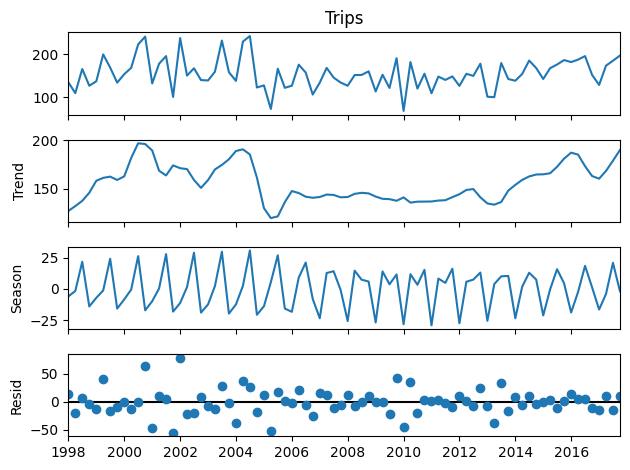

In [45]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Supongamos que ya tienes el DataFrame con una columna 'Employed' y una columna de fecha llamada 'date'
# Asegúrate de que 'date' sea el índice y que tenga una frecuencia definida
# Ejemplo: us_e_1990 = pd.read_csv('data.csv', parse_dates=['date'], index_col='date')

# Verifica y establece la frecuencia si es necesario
df_p = df_B.asfreq('ME')  # Ajusta la frecuencia según sea necesario (mensual en este caso)

stl = STL(df_B['Trips'], seasonal=13)
result = stl.fit()

# Graficar los componentes
result.plot()
plt.show()

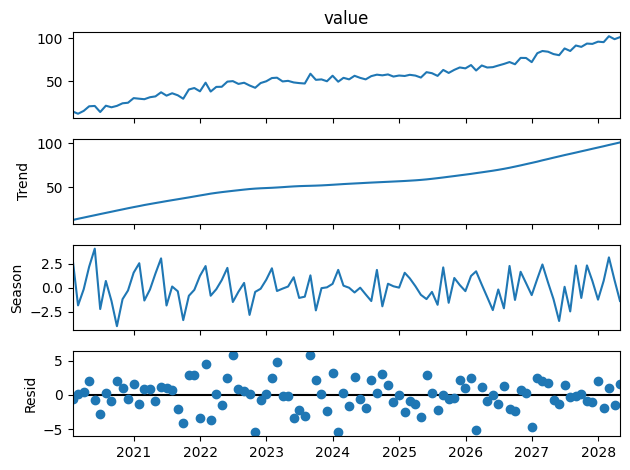

Tendencia: date
2020-01-31    13.065614
2020-02-29    14.404275
2020-03-31    15.742593
2020-04-30    17.080782
2020-05-31    18.418298
Name: trend, dtype: float64
Estacionalidad: date
2020-01-31    2.879250
2020-02-29   -1.827631
2020-03-31   -0.155446
2020-04-30    2.189656
2020-05-31    4.078433
Name: season, dtype: float64
Residuos: date
2020-01-31   -0.652707
2020-02-29    0.167158
2020-03-31    0.433174
2020-04-30    2.072027
2020-05-31   -0.746214
Name: resid, dtype: float64


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Crear una serie temporal ficticia
np.random.seed(0)
date_range = pd.date_range(start='2020-01-01', periods=100, freq='ME')
trend = np.linspace(10, 100, 100)  # Componente de tendencia
seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi, 100))  # Componente estacional
noise = np.random.normal(0, 3, 100)  # Componente de ruido
series = trend + seasonality + noise

# Crear DataFrame con la serie temporal
df2 = pd.DataFrame({'date': date_range, 'value': series})
df2.set_index('date', inplace=True)

# Aplicar STL para descomponer la serie temporal
stl = STL(df2['value'], seasonal=13)
result = stl.fit()

# Graficar los componentes
result.plot()
plt.show()

# Acceso a los componentes individuales (tendencia, estacionalidad y residuo)
trend_component = result.trend
seasonal_component = result.seasonal
residual_component = result.resid

# Mostrar los primeros valores de los componentes
print("Tendencia:", trend_component.head())
print("Estacionalidad:", seasonal_component.head())
print("Residuos:", residual_component.head())


In [34]:
df2

,value
date,
2020-01-31,15.292157
2020-02-29,12.743802
2020-03-31,16.020320
2020-04-30,21.342465
2020-05-31,21.750517
...,...
2027-12-31,95.971876
2028-01-31,95.411715
2028-02-29,102.273505
